In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import itertools
import logging
import os.path as osp
import tempfile

import mmcv
import numpy as np
from mmcv.utils import print_log
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

try:
    import pycocotools
    assert pycocotools.__version__ >= '12.0.2'
except AssertionError:
    raise AssertionError('Incompatible version of pycocotools is installed. '
                         'Run pip uninstall pycocotools first. Then run pip '
                         'install mmpycocotools to install open-mmlab forked '
                         'pycocotools.')

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        """Load annotation from COCO style annotation file.

        Args:
            ann_file (str): Path of annotation file.

        Returns:
            list[dict]: Annotation info from COCO api.
        """

        self.coco = COCO(ann_file)
        self.cat_ids = self.coco.get_cat_ids(cat_names=self.CLASSES)
        self.cat2label = {cat_id: i for i, cat_id in enumerate(self.cat_ids)}
        self.img_ids = self.coco.get_img_ids()
        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def get_ann_info(self, idx):
        """Get COCO annotation by index.

        Args:
            idx (int): Index of data.

        Returns:
            dict: Annotation info of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return self._parse_ann_info(self.data_infos[idx], ann_info)

    def get_cat_ids(self, idx):
        """Get COCO category ids by index.

        Args:
            idx (int): Index of data.

        Returns:
            list[int]: All categories in the image of specified index.
        """

        img_id = self.data_infos[idx]['id']
        ann_ids = self.coco.get_ann_ids(img_ids=[img_id])
        ann_info = self.coco.load_anns(ann_ids)
        return [ann['category_id'] for ann in ann_info]

    def _filter_imgs(self, min_size=32):
        """Filter images too small or without ground truths."""
        valid_inds = []
        ids_with_ann = set(_['image_id'] for _ in self.coco.anns.values())
        for i, img_info in enumerate(self.data_infos):
            if self.filter_empty_gt and self.img_ids[i] not in ids_with_ann:
                continue
            if min(img_info['width'], img_info['height']) >= min_size:
                valid_inds.append(i)
        return valid_inds

    def get_subset_by_classes(self):
        """Get img ids that contain any category in class_ids.

        Different from the coco.getImgIds(), this function returns the id if
        the img contains one of the categories rather than all.

        Args:
            class_ids (list[int]): list of category ids

        Return:
            ids (list[int]): integer list of img ids
        """

        ids = set()
        for i, class_id in enumerate(self.cat_ids):
            ids |= set(self.coco.cat_img_map[class_id])
        self.img_ids = list(ids)

        data_infos = []
        for i in self.img_ids:
            info = self.coco.load_imgs([i])[0]
            info['filename'] = info['file_name']
            data_infos.append(info)
        return data_infos

    def _parse_ann_info(self, img_info, ann_info):
        """Parse bbox and mask annotation.

        Args:
            ann_info (list[dict]): Annotation info of an image.
            with_mask (bool): Whether to parse mask annotations.

        Returns:
            dict: A dict containing the following keys: bboxes, bboxes_ignore,\
                labels, masks, seg_map. "masks" are raw annotations and not \
                decoded into binary masks.
        """
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_masks_ann = []
        for i, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            inter_w = max(0, min(x1 + w, img_info['width']) - max(x1, 0))
            inter_h = max(0, min(y1 + h, img_info['height']) - max(y1, 0))
            if inter_w * inter_h == 0:
                continue
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            if ann['category_id'] not in self.cat_ids:
                continue
            bbox = [x1, y1, x1 + w, y1 + h]
            if ann.get('iscrowd', False):
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])
                gt_masks_ann.append(ann.get('segmentation', None))

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        seg_map = img_info['filename'].replace('jpg', 'png')

        ann = dict(
            bboxes=gt_bboxes,
            labels=gt_labels,
            bboxes_ignore=gt_bboxes_ignore,
            masks=gt_masks_ann,
            seg_map=seg_map)

        return ann

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/dynamic_rcnn/dynamic_rcnn_r101_fpn_1x .py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'lotte_data/'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'datasets/'
cfg.data.train.ann_file = 'train/traincoco.json'
cfg.data.train.img_prefix = 'train/images/'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'datasets/'
cfg.data.val.ann_file = 'val/valcoco.json'
cfg.data.val.img_prefix = 'val/images/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'datasets/'
cfg.data.test.ann_file = 'test/testcoco.json'
cfg.data.test.img_prefix = 'test/images/'

# num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 22
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet101',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(t

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


2020-10-01 15:22:40,542 - mmdet - INFO - load model from: torchvision://resnet101
2020-10-01 15:22:40,746 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2020-10-01 15:22:42,013 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-10-01 15:22:42,013 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


2020-10-01 15:22:51,341 - mmdet - INFO - Epoch [1][10/601]	lr: 4.746e-05, eta: 1:41:37, time: 0.847, data_time: 0.213, memory: 5684, loss_rpn_cls: 0.6926, loss_rpn_bbox: 0.0715, loss_cls: 2.5723, acc: 62.8809, loss_bbox: 0.0127, loss: 3.3491
2020-10-01 15:22:57,146 - mmdet - INFO - Epoch [1][20/601]	lr: 9.741e-05, eta: 1:25:32, time: 0.581, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.6911, loss_rpn_bbox: 0.0729, loss_cls: 0.9499, acc: 97.5391, loss_bbox: 0.0236, loss: 1.7376
2020-10-01 15:23:02,890 - mmdet - INFO - Epoch [1][30/601]	lr: 1.474e-04, eta: 1:19:52, time: 0.574, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.6729, loss_rpn_bbox: 0.0969, loss_cls: 0.2494, acc: 96.7969, loss_bbox: 0.0374, loss: 1.0566
2020-10-01 15:23:08,950 - mmdet - INFO - Epoch [1][40/601]	lr: 1.973e-04, eta: 1:17:55, time: 0.606, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.6091, loss_rpn_bbox: 0.0789, loss_cls: 0.4390, acc: 94.7754, loss_bbox: 0.0876, loss: 1.2146
2020-10-01 15:23:14,958 - mmdet 

2020-10-01 15:26:11,413 - mmdet - INFO - Epoch [1][350/601]	lr: 1.746e-03, eta: 1:08:08, time: 0.608, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0241, loss_rpn_bbox: 0.0629, loss_cls: 0.3046, acc: 90.0195, loss_bbox: 0.2704, loss: 0.6620
2020-10-01 15:26:17,677 - mmdet - INFO - Epoch [1][360/601]	lr: 1.796e-03, eta: 1:08:08, time: 0.626, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0201, loss_rpn_bbox: 0.0565, loss_cls: 0.2784, acc: 90.5273, loss_bbox: 0.2619, loss: 0.6169
2020-10-01 15:26:23,870 - mmdet - INFO - Epoch [1][370/601]	lr: 1.846e-03, eta: 1:08:06, time: 0.619, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0213, loss_rpn_bbox: 0.0469, loss_cls: 0.2695, acc: 91.1328, loss_bbox: 0.2465, loss: 0.5842
2020-10-01 15:26:29,757 - mmdet - INFO - Epoch [1][380/601]	lr: 1.896e-03, eta: 1:07:59, time: 0.589, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0192, loss_rpn_bbox: 0.0496, loss_cls: 0.2854, acc: 90.4102, loss_bbox: 0.3000, loss: 0.6542
2020-10-01 15:26:35,899 - mm

2020-10-01 15:29:38,612 - mmdet - INFO - Epoch [2][90/601]	lr: 2.500e-03, eta: 1:05:17, time: 0.605, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0089, loss_rpn_bbox: 0.0428, loss_cls: 0.1490, acc: 94.5605, loss_bbox: 0.1558, loss: 0.3565
2020-10-01 15:29:44,870 - mmdet - INFO - Epoch [2][100/601]	lr: 2.500e-03, eta: 1:05:13, time: 0.626, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0182, loss_rpn_bbox: 0.0414, loss_cls: 0.1487, acc: 94.6973, loss_bbox: 0.1427, loss: 0.3510
2020-10-01 15:29:50,705 - mmdet - INFO - Epoch [2][110/601]	lr: 2.500e-03, eta: 1:05:06, time: 0.584, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0132, loss_rpn_bbox: 0.0484, loss_cls: 0.1560, acc: 94.6484, loss_bbox: 0.1419, loss: 0.3595
2020-10-01 15:29:57,004 - mmdet - INFO - Epoch [2][120/601]	lr: 2.500e-03, eta: 1:05:02, time: 0.630, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0084, loss_rpn_bbox: 0.0408, loss_cls: 0.1984, acc: 93.7109, loss_bbox: 0.1509, loss: 0.3984
2020-10-01 15:30:02,716 - mmd

2020-10-01 15:33:03,375 - mmdet - INFO - Epoch [2][430/601]	lr: 2.500e-03, eta: 1:01:56, time: 0.612, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0078, loss_rpn_bbox: 0.0382, loss_cls: 0.1370, acc: 94.5020, loss_bbox: 0.1290, loss: 0.3120
2020-10-01 15:33:09,393 - mmdet - INFO - Epoch [2][440/601]	lr: 2.500e-03, eta: 1:01:50, time: 0.602, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0090, loss_rpn_bbox: 0.0395, loss_cls: 0.1228, acc: 95.0684, loss_bbox: 0.1191, loss: 0.2905
2020-10-01 15:33:15,513 - mmdet - INFO - Epoch [2][450/601]	lr: 2.500e-03, eta: 1:01:45, time: 0.612, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0093, loss_rpn_bbox: 0.0395, loss_cls: 0.1355, acc: 94.8828, loss_bbox: 0.1343, loss: 0.3186
2020-10-01 15:33:21,495 - mmdet - INFO - Epoch [2][460/601]	lr: 2.500e-03, eta: 1:01:38, time: 0.598, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0099, loss_rpn_bbox: 0.0375, loss_cls: 0.1230, acc: 95.1855, loss_bbox: 0.1271, loss: 0.2976
2020-10-01 15:33:27,535 - mm

2020-10-01 15:36:32,435 - mmdet - INFO - Epoch [3][170/601]	lr: 2.500e-03, eta: 0:58:45, time: 0.621, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0071, loss_rpn_bbox: 0.0323, loss_cls: 0.1439, acc: 94.6484, loss_bbox: 0.1279, loss: 0.3112
2020-10-01 15:36:38,487 - mmdet - INFO - Epoch [3][180/601]	lr: 2.500e-03, eta: 0:58:39, time: 0.605, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0063, loss_rpn_bbox: 0.0309, loss_cls: 0.1340, acc: 95.0195, loss_bbox: 0.1295, loss: 0.3007
2020-10-01 15:36:44,434 - mmdet - INFO - Epoch [3][190/601]	lr: 2.500e-03, eta: 0:58:33, time: 0.595, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0313, loss_cls: 0.1578, acc: 94.3555, loss_bbox: 0.1348, loss: 0.3288
2020-10-01 15:36:50,387 - mmdet - INFO - Epoch [3][200/601]	lr: 2.500e-03, eta: 0:58:27, time: 0.595, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0069, loss_rpn_bbox: 0.0302, loss_cls: 0.1494, acc: 94.6484, loss_bbox: 0.1202, loss: 0.3067
2020-10-01 15:36:56,685 - mm

2020-10-01 15:39:55,823 - mmdet - INFO - Epoch [3][510/601]	lr: 2.500e-03, eta: 0:55:14, time: 0.616, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0046, loss_rpn_bbox: 0.0272, loss_cls: 0.1296, acc: 95.2148, loss_bbox: 0.1103, loss: 0.2718
2020-10-01 15:40:01,887 - mmdet - INFO - Epoch [3][520/601]	lr: 2.500e-03, eta: 0:55:08, time: 0.606, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0050, loss_rpn_bbox: 0.0267, loss_cls: 0.1271, acc: 95.3320, loss_bbox: 0.1038, loss: 0.2626
2020-10-01 15:40:07,953 - mmdet - INFO - Epoch [3][530/601]	lr: 2.500e-03, eta: 0:55:02, time: 0.607, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0327, loss_cls: 0.1146, acc: 95.4980, loss_bbox: 0.1060, loss: 0.2596
2020-10-01 15:40:14,205 - mmdet - INFO - Epoch [3][540/601]	lr: 2.500e-03, eta: 0:54:57, time: 0.625, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0310, loss_cls: 0.1123, acc: 95.7227, loss_bbox: 0.1018, loss: 0.2509
2020-10-01 15:40:20,242 - mm

2020-10-01 15:43:24,241 - mmdet - INFO - Epoch [4][250/601]	lr: 2.500e-03, eta: 0:51:54, time: 0.600, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0293, loss_cls: 0.1278, acc: 95.5273, loss_bbox: 0.1002, loss: 0.2608
2020-10-01 15:43:30,316 - mmdet - INFO - Epoch [4][260/601]	lr: 2.500e-03, eta: 0:51:48, time: 0.607, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0271, loss_cls: 0.1168, acc: 95.6445, loss_bbox: 0.1000, loss: 0.2481
2020-10-01 15:43:36,346 - mmdet - INFO - Epoch [4][270/601]	lr: 2.500e-03, eta: 0:51:42, time: 0.603, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0278, loss_cls: 0.1150, acc: 95.3711, loss_bbox: 0.1140, loss: 0.2609
2020-10-01 15:43:42,702 - mmdet - INFO - Epoch [4][280/601]	lr: 2.500e-03, eta: 0:51:37, time: 0.636, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0247, loss_cls: 0.1154, acc: 95.5273, loss_bbox: 0.1058, loss: 0.2501
2020-10-01 15:43:48,562 - mm

2020-10-01 15:46:51,284 - mmdet - INFO - Epoch [4][590/601]	lr: 2.500e-03, eta: 0:48:32, time: 0.619, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0271, loss_cls: 0.1307, acc: 95.3125, loss_bbox: 0.1129, loss: 0.2735
2020-10-01 15:46:57,225 - mmdet - INFO - Epoch [4][600/601]	lr: 2.500e-03, eta: 0:48:26, time: 0.594, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0219, loss_cls: 0.1190, acc: 95.5762, loss_bbox: 0.1048, loss: 0.2499
2020-10-01 15:47:06,439 - mmdet - INFO - Epoch [5][10/601]	lr: 2.500e-03, eta: 0:48:23, time: 0.851, data_time: 0.213, memory: 5684, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0231, loss_cls: 0.1146, acc: 96.1230, loss_bbox: 0.0880, loss: 0.2295
2020-10-01 15:47:12,989 - mmdet - INFO - Epoch [5][20/601]	lr: 2.500e-03, eta: 0:48:18, time: 0.655, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0271, loss_cls: 0.1322, acc: 95.9277, loss_bbox: 0.0934, loss: 0.2568
2020-10-01 15:47:19,139 - mmde

2020-10-01 15:50:25,912 - mmdet - INFO - Epoch [5][330/601]	lr: 2.500e-03, eta: 0:45:19, time: 0.634, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0264, loss_cls: 0.0955, acc: 95.9961, loss_bbox: 0.0898, loss: 0.2146
2020-10-01 15:50:32,121 - mmdet - INFO - Epoch [5][340/601]	lr: 2.500e-03, eta: 0:45:13, time: 0.621, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0248, loss_cls: 0.1205, acc: 95.4199, loss_bbox: 0.1000, loss: 0.2480
2020-10-01 15:50:38,349 - mmdet - INFO - Epoch [5][350/601]	lr: 2.500e-03, eta: 0:45:07, time: 0.623, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0228, loss_cls: 0.1108, acc: 96.0254, loss_bbox: 0.1019, loss: 0.2385
2020-10-01 15:50:44,921 - mmdet - INFO - Epoch [5][360/601]	lr: 2.500e-03, eta: 0:45:02, time: 0.657, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0219, loss_cls: 0.1120, acc: 95.6055, loss_bbox: 0.1070, loss: 0.2447
2020-10-01 15:50:51,682 - mm

2020-10-01 15:54:09,241 - mmdet - INFO - Epoch [6][70/601]	lr: 2.500e-03, eta: 0:42:13, time: 0.662, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0224, loss_cls: 0.1068, acc: 96.0449, loss_bbox: 0.0818, loss: 0.2160
2020-10-01 15:54:15,657 - mmdet - INFO - Epoch [6][80/601]	lr: 2.500e-03, eta: 0:42:07, time: 0.642, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0227, loss_cls: 0.1051, acc: 96.2793, loss_bbox: 0.0784, loss: 0.2083
2020-10-01 15:54:21,902 - mmdet - INFO - Epoch [6][90/601]	lr: 2.500e-03, eta: 0:42:01, time: 0.624, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0024, loss_rpn_bbox: 0.0236, loss_cls: 0.1142, acc: 96.0254, loss_bbox: 0.0850, loss: 0.2252
2020-10-01 15:54:28,089 - mmdet - INFO - Epoch [6][100/601]	lr: 2.500e-03, eta: 0:41:55, time: 0.619, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0247, loss_cls: 0.0938, acc: 96.3281, loss_bbox: 0.0833, loss: 0.2043
2020-10-01 15:54:34,271 - mmdet

2020-10-01 15:57:45,349 - mmdet - INFO - Epoch [6][410/601]	lr: 2.500e-03, eta: 0:38:53, time: 0.630, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0223, loss_cls: 0.1129, acc: 95.5859, loss_bbox: 0.0961, loss: 0.2339
2020-10-01 15:57:51,592 - mmdet - INFO - Epoch [6][420/601]	lr: 2.500e-03, eta: 0:38:47, time: 0.624, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0229, loss_cls: 0.0871, acc: 96.7188, loss_bbox: 0.0802, loss: 0.1933
2020-10-01 15:57:57,968 - mmdet - INFO - Epoch [6][430/601]	lr: 2.500e-03, eta: 0:38:41, time: 0.638, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0242, loss_cls: 0.0966, acc: 96.2988, loss_bbox: 0.0974, loss: 0.2195
2020-10-01 15:58:03,936 - mmdet - INFO - Epoch [6][440/601]	lr: 2.500e-03, eta: 0:38:35, time: 0.597, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0214, loss_cls: 0.1042, acc: 95.9570, loss_bbox: 0.0944, loss: 0.2228
2020-10-01 15:58:09,995 - mm

2020-10-01 16:01:22,267 - mmdet - INFO - Epoch [7][150/601]	lr: 2.500e-03, eta: 0:35:30, time: 0.658, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0223, loss_cls: 0.0927, acc: 96.7578, loss_bbox: 0.0858, loss: 0.2035
2020-10-01 16:01:28,617 - mmdet - INFO - Epoch [7][160/601]	lr: 2.500e-03, eta: 0:35:24, time: 0.635, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0216, loss_cls: 0.1110, acc: 96.6406, loss_bbox: 0.0793, loss: 0.2154
2020-10-01 16:01:35,109 - mmdet - INFO - Epoch [7][170/601]	lr: 2.500e-03, eta: 0:35:18, time: 0.649, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0215, loss_cls: 0.1055, acc: 96.6504, loss_bbox: 0.0809, loss: 0.2128
2020-10-01 16:01:41,453 - mmdet - INFO - Epoch [7][180/601]	lr: 2.500e-03, eta: 0:35:12, time: 0.634, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0226, loss_cls: 0.1118, acc: 96.5723, loss_bbox: 0.0862, loss: 0.2234
2020-10-01 16:01:48,031 - mm

2020-10-01 16:04:56,300 - mmdet - INFO - Epoch [7][490/601]	lr: 2.500e-03, eta: 0:32:04, time: 0.617, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0195, loss_cls: 0.0818, acc: 96.8164, loss_bbox: 0.0776, loss: 0.1810
2020-10-01 16:05:02,826 - mmdet - INFO - Epoch [7][500/601]	lr: 2.500e-03, eta: 0:31:58, time: 0.653, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0205, loss_cls: 0.0887, acc: 96.4062, loss_bbox: 0.0834, loss: 0.1947
2020-10-01 16:05:09,072 - mmdet - INFO - Epoch [7][510/601]	lr: 2.500e-03, eta: 0:31:52, time: 0.625, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0180, loss_cls: 0.0879, acc: 96.6504, loss_bbox: 0.0826, loss: 0.1911
2020-10-01 16:05:15,351 - mmdet - INFO - Epoch [7][520/601]	lr: 2.500e-03, eta: 0:31:46, time: 0.628, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0217, loss_cls: 0.1057, acc: 96.0059, loss_bbox: 0.0905, loss: 0.2207
2020-10-01 16:05:21,805 - mm

2020-10-01 16:08:33,927 - mmdet - INFO - Epoch [8][230/601]	lr: 2.500e-03, eta: 0:28:37, time: 0.639, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0210, loss_cls: 0.1116, acc: 96.9336, loss_bbox: 0.0801, loss: 0.2153
2020-10-01 16:08:41,145 - mmdet - INFO - Epoch [8][240/601]	lr: 2.500e-03, eta: 0:28:32, time: 0.721, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0195, loss_cls: 0.1622, acc: 96.7188, loss_bbox: 0.0824, loss: 0.2657
2020-10-01 16:08:48,333 - mmdet - INFO - Epoch [8][250/601]	lr: 2.500e-03, eta: 0:28:26, time: 0.719, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0209, loss_cls: 0.1336, acc: 96.6211, loss_bbox: 0.0825, loss: 0.2388
2020-10-01 16:08:55,821 - mmdet - INFO - Epoch [8][260/601]	lr: 2.500e-03, eta: 0:28:21, time: 0.749, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0203, loss_cls: 0.1195, acc: 96.1230, loss_bbox: 0.0817, loss: 0.2238
2020-10-01 16:09:02,197 - mm

2020-10-01 16:12:14,794 - mmdet - INFO - Epoch [8][570/601]	lr: 2.500e-03, eta: 0:25:12, time: 0.688, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0215, loss_cls: 0.0891, acc: 96.5918, loss_bbox: 0.0835, loss: 0.1971
2020-10-01 16:12:21,349 - mmdet - INFO - Epoch [8][580/601]	lr: 2.500e-03, eta: 0:25:06, time: 0.655, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0212, loss_cls: 0.0945, acc: 96.2500, loss_bbox: 0.0827, loss: 0.2011
2020-10-01 16:12:28,255 - mmdet - INFO - Epoch [8][590/601]	lr: 2.500e-03, eta: 0:25:00, time: 0.691, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0046, loss_rpn_bbox: 0.0172, loss_cls: 0.0865, acc: 96.6895, loss_bbox: 0.0775, loss: 0.1859
2020-10-01 16:12:34,809 - mmdet - INFO - Epoch [8][600/601]	lr: 2.500e-03, eta: 0:24:54, time: 0.655, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0181, loss_cls: 0.1075, acc: 95.8301, loss_bbox: 0.0943, loss: 0.2218
2020-10-01 16:12:44,176 - mm

2020-10-01 16:15:57,796 - mmdet - INFO - Epoch [9][310/601]	lr: 2.500e-04, eta: 0:21:44, time: 0.681, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0153, loss_cls: 0.0908, acc: 97.0508, loss_bbox: 0.0626, loss: 0.1705
2020-10-01 16:16:04,136 - mmdet - INFO - Epoch [9][320/601]	lr: 2.500e-04, eta: 0:21:38, time: 0.634, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0026, loss_rpn_bbox: 0.0168, loss_cls: 0.0784, acc: 96.7480, loss_bbox: 0.0663, loss: 0.1641
2020-10-01 16:16:10,630 - mmdet - INFO - Epoch [9][330/601]	lr: 2.500e-04, eta: 0:21:32, time: 0.649, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0149, loss_cls: 0.0817, acc: 96.7773, loss_bbox: 0.0667, loss: 0.1646
2020-10-01 16:16:17,485 - mmdet - INFO - Epoch [9][340/601]	lr: 2.500e-04, eta: 0:21:26, time: 0.686, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0174, loss_cls: 0.0954, acc: 96.7090, loss_bbox: 0.0701, loss: 0.1867
2020-10-01 16:16:23,565 - mm

2020-10-01 16:19:34,820 - mmdet - INFO - Epoch [10][50/601]	lr: 2.500e-04, eta: 0:18:13, time: 0.609, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0154, loss_cls: 0.0796, acc: 97.1777, loss_bbox: 0.0618, loss: 0.1588
2020-10-01 16:19:40,902 - mmdet - INFO - Epoch [10][60/601]	lr: 2.500e-04, eta: 0:18:07, time: 0.608, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0140, loss_cls: 0.0856, acc: 96.8066, loss_bbox: 0.0642, loss: 0.1669
2020-10-01 16:19:46,947 - mmdet - INFO - Epoch [10][70/601]	lr: 2.500e-04, eta: 0:18:01, time: 0.605, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0138, loss_cls: 0.0717, acc: 97.4707, loss_bbox: 0.0560, loss: 0.1427
2020-10-01 16:19:52,812 - mmdet - INFO - Epoch [10][80/601]	lr: 2.500e-04, eta: 0:17:54, time: 0.587, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0150, loss_cls: 0.0865, acc: 96.8066, loss_bbox: 0.0691, loss: 0.1726
2020-10-01 16:19:59,003 - mm

2020-10-01 16:23:01,394 - mmdet - INFO - Epoch [10][390/601]	lr: 2.500e-04, eta: 0:14:40, time: 0.588, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0146, loss_cls: 0.0810, acc: 96.8457, loss_bbox: 0.0621, loss: 0.1598
2020-10-01 16:23:07,485 - mmdet - INFO - Epoch [10][400/601]	lr: 2.500e-04, eta: 0:14:33, time: 0.609, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0153, loss_cls: 0.0809, acc: 97.0117, loss_bbox: 0.0688, loss: 0.1675
2020-10-01 16:23:13,687 - mmdet - INFO - Epoch [10][410/601]	lr: 2.500e-04, eta: 0:14:27, time: 0.620, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0161, loss_cls: 0.0940, acc: 96.7871, loss_bbox: 0.0696, loss: 0.1829
2020-10-01 16:23:19,632 - mmdet - INFO - Epoch [10][420/601]	lr: 2.500e-04, eta: 0:14:21, time: 0.595, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0135, loss_cls: 0.0784, acc: 97.0605, loss_bbox: 0.0607, loss: 0.1547
2020-10-01 16:23:25,906 

2020-10-01 16:26:29,930 - mmdet - INFO - Epoch [11][130/601]	lr: 2.500e-04, eta: 0:11:07, time: 0.603, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0150, loss_cls: 0.0758, acc: 97.0898, loss_bbox: 0.0603, loss: 0.1527
2020-10-01 16:26:36,258 - mmdet - INFO - Epoch [11][140/601]	lr: 2.500e-04, eta: 0:11:00, time: 0.633, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0160, loss_cls: 0.0963, acc: 96.9043, loss_bbox: 0.0645, loss: 0.1781
2020-10-01 16:26:42,245 - mmdet - INFO - Epoch [11][150/601]	lr: 2.500e-04, eta: 0:10:54, time: 0.599, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0009, loss_rpn_bbox: 0.0150, loss_cls: 0.0691, acc: 97.3828, loss_bbox: 0.0573, loss: 0.1424
2020-10-01 16:26:48,439 - mmdet - INFO - Epoch [11][160/601]	lr: 2.500e-04, eta: 0:10:48, time: 0.619, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0178, loss_cls: 0.0858, acc: 97.2070, loss_bbox: 0.0607, loss: 0.1656
2020-10-01 16:26:54,287 

2020-10-01 16:29:56,829 - mmdet - INFO - Epoch [11][470/601]	lr: 2.500e-04, eta: 0:07:34, time: 0.599, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0150, loss_cls: 0.0878, acc: 97.0508, loss_bbox: 0.0621, loss: 0.1675
2020-10-01 16:30:02,928 - mmdet - INFO - Epoch [11][480/601]	lr: 2.500e-04, eta: 0:07:28, time: 0.610, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0156, loss_cls: 0.0805, acc: 97.1094, loss_bbox: 0.0654, loss: 0.1643
2020-10-01 16:30:09,123 - mmdet - INFO - Epoch [11][490/601]	lr: 2.500e-04, eta: 0:07:22, time: 0.619, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0124, loss_cls: 0.0718, acc: 97.7637, loss_bbox: 0.0556, loss: 0.1426
2020-10-01 16:30:15,085 - mmdet - INFO - Epoch [11][500/601]	lr: 2.500e-04, eta: 0:07:16, time: 0.596, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0133, loss_cls: 0.0757, acc: 97.3633, loss_bbox: 0.0541, loss: 0.1445
2020-10-01 16:30:21,324 

2020-10-01 16:33:26,289 - mmdet - INFO - Epoch [12][210/601]	lr: 2.500e-05, eta: 0:04:02, time: 0.588, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0027, loss_rpn_bbox: 0.0137, loss_cls: 0.0733, acc: 97.3242, loss_bbox: 0.0607, loss: 0.1504
2020-10-01 16:33:32,268 - mmdet - INFO - Epoch [12][220/601]	lr: 2.500e-05, eta: 0:03:56, time: 0.598, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0143, loss_cls: 0.0818, acc: 96.9336, loss_bbox: 0.0630, loss: 0.1611
2020-10-01 16:33:38,250 - mmdet - INFO - Epoch [12][230/601]	lr: 2.500e-05, eta: 0:03:50, time: 0.598, data_time: 0.005, memory: 5684, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0170, loss_cls: 0.0703, acc: 97.2168, loss_bbox: 0.0619, loss: 0.1507
2020-10-01 16:33:44,412 - mmdet - INFO - Epoch [12][240/601]	lr: 2.500e-05, eta: 0:03:44, time: 0.616, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0153, loss_cls: 0.0811, acc: 97.0410, loss_bbox: 0.0587, loss: 0.1563
2020-10-01 16:33:50,364 

2020-10-01 16:36:51,854 - mmdet - INFO - Epoch [12][550/601]	lr: 2.500e-05, eta: 0:00:31, time: 0.603, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0136, loss_cls: 0.0775, acc: 97.3926, loss_bbox: 0.0533, loss: 0.1466
2020-10-01 16:36:57,927 - mmdet - INFO - Epoch [12][560/601]	lr: 2.500e-05, eta: 0:00:25, time: 0.607, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0138, loss_cls: 0.0746, acc: 97.4219, loss_bbox: 0.0574, loss: 0.1474
2020-10-01 16:37:03,857 - mmdet - INFO - Epoch [12][570/601]	lr: 2.500e-05, eta: 0:00:19, time: 0.593, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0144, loss_cls: 0.0679, acc: 97.5781, loss_bbox: 0.0548, loss: 0.1386
2020-10-01 16:37:09,926 - mmdet - INFO - Epoch [12][580/601]	lr: 2.500e-05, eta: 0:00:13, time: 0.607, data_time: 0.004, memory: 5684, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0139, loss_cls: 0.0794, acc: 97.1973, loss_bbox: 0.0558, loss: 0.1504
2020-10-01 16:37:16,212 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 401/401, 8.3 task/s, elapsed: 48s, ETA:     0s

2020-10-01 16:38:17,160 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 168 | 175  | 0.988  | 0.988 |
| buttering        | 120 | 129  | 1.000  | 0.990 |
| couque_coffee    | 176 | 184  | 0.977  | 0.969 |
| chocopie         | 181 | 186  | 0.989  | 0.982 |
| cidar            | 164 | 170  | 0.982  | 0.982 |
| couque_white     | 171 | 200  | 0.971  | 0.949 |
| coke             | 179 | 187  | 0.994  | 0.994 |
| diget_ori        | 173 | 194  | 0.983  | 0.971 |
| diget_choco      | 196 | 229  | 0.969  | 0.963 |
| gumi_gumi        | 116 | 116  | 0.991  | 0.991 |
| homerunball      | 172 | 175  | 0.983  | 0.983 |
| jjolbyung_noodle | 153 | 153  | 0.987  | 0.986 |
| juicyfresh       | 165 | 167  | 0.970  | 0.969 |
| jjolbyung_ori    | 147 | 145  | 0.986  | 0.986 |
| spearmint        | 135 | 138  | 0.948  | 0.944 |
| squid_peanut     | 157 | 159  | 1.000 

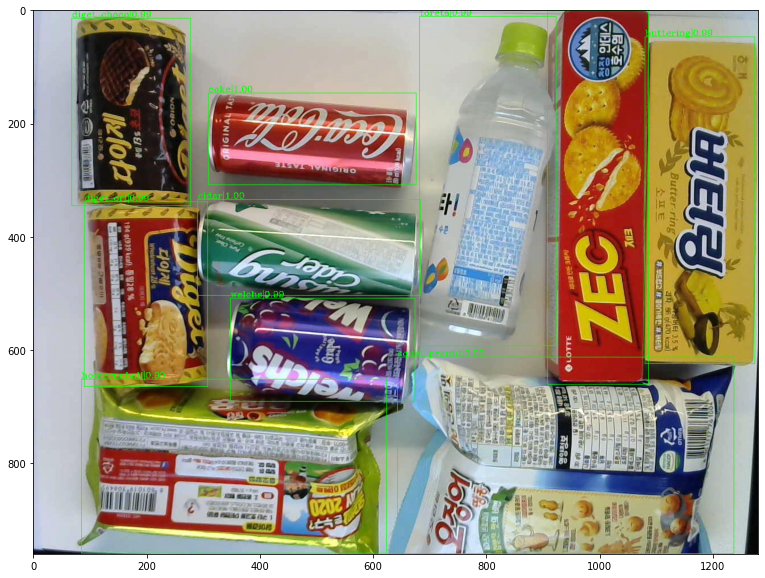

In [7]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('datasets/train/images/0046.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [9]:
torch.save(model.state_dict(), 'save_state_dict/Dynamic_RCNN_model_state_dict.pt')

In [10]:
torch.save(model, 'save_model/Dynamic_RCNN_model.pt')